Insurance companies invest a lot of [time and money](https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf) into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries insurance it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

Knowing all of this, On the Road car insurance have requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [252]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

df_insurance = pd.read_csv('car_insurance.csv', index_col = 'id')
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 569520 to 442696
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  int64  
 1   gender               10000 non-null  int64  
 2   driving_experience   10000 non-null  object 
 3   education            10000 non-null  object 
 4   income               10000 non-null  object 
 5   credit_score         9018 non-null   float64
 6   vehicle_ownership    10000 non-null  float64
 7   vehicle_year         10000 non-null  object 
 8   married              10000 non-null  float64
 9   children             10000 non-null  float64
 10  postal_code          10000 non-null  int64  
 11  annual_mileage       9043 non-null   float64
 12  vehicle_type         10000 non-null  object 
 13  speeding_violations  10000 non-null  int64  
 14  duis                 10000 non-null  int64  
 15  past_accidents       10000 non

['high school' 'none' 'university']
['upper class' 'poverty' 'working class' 'middle class']
['0-9y' '10-19y' '20-29y' '30y+']
[3 0 1 2]


,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
id,,,,,,,,,,,,,,,,,
569520,65+,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0
750365,16-25,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1
199901,16-25,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0
478866,16-25,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0
731664,26-39,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1


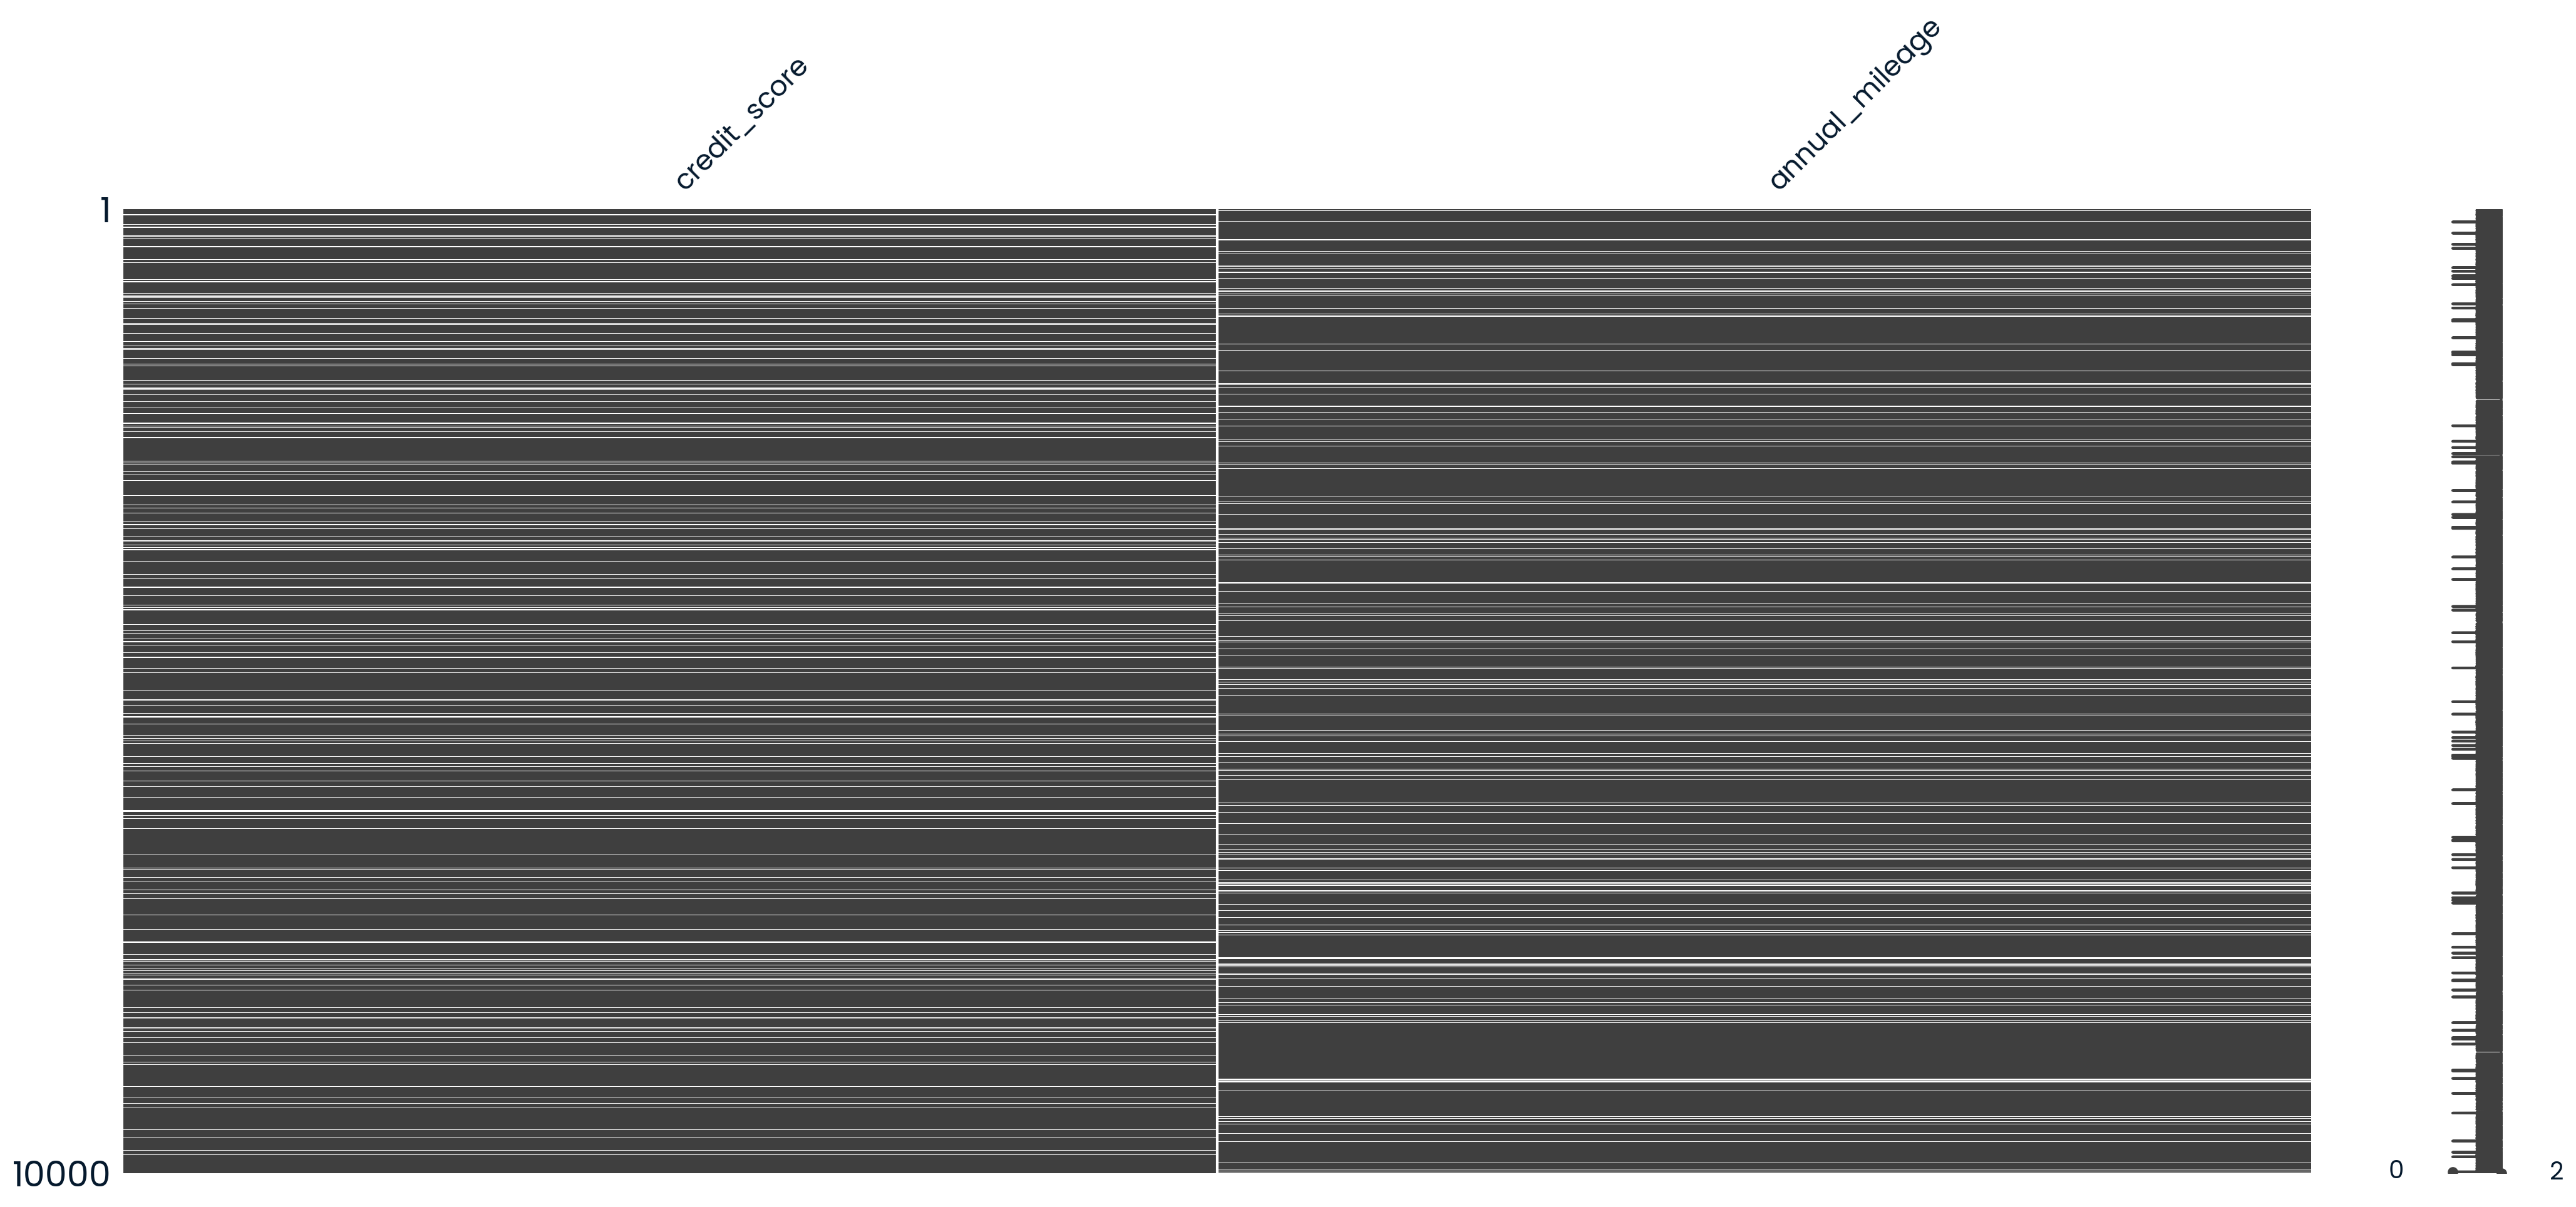

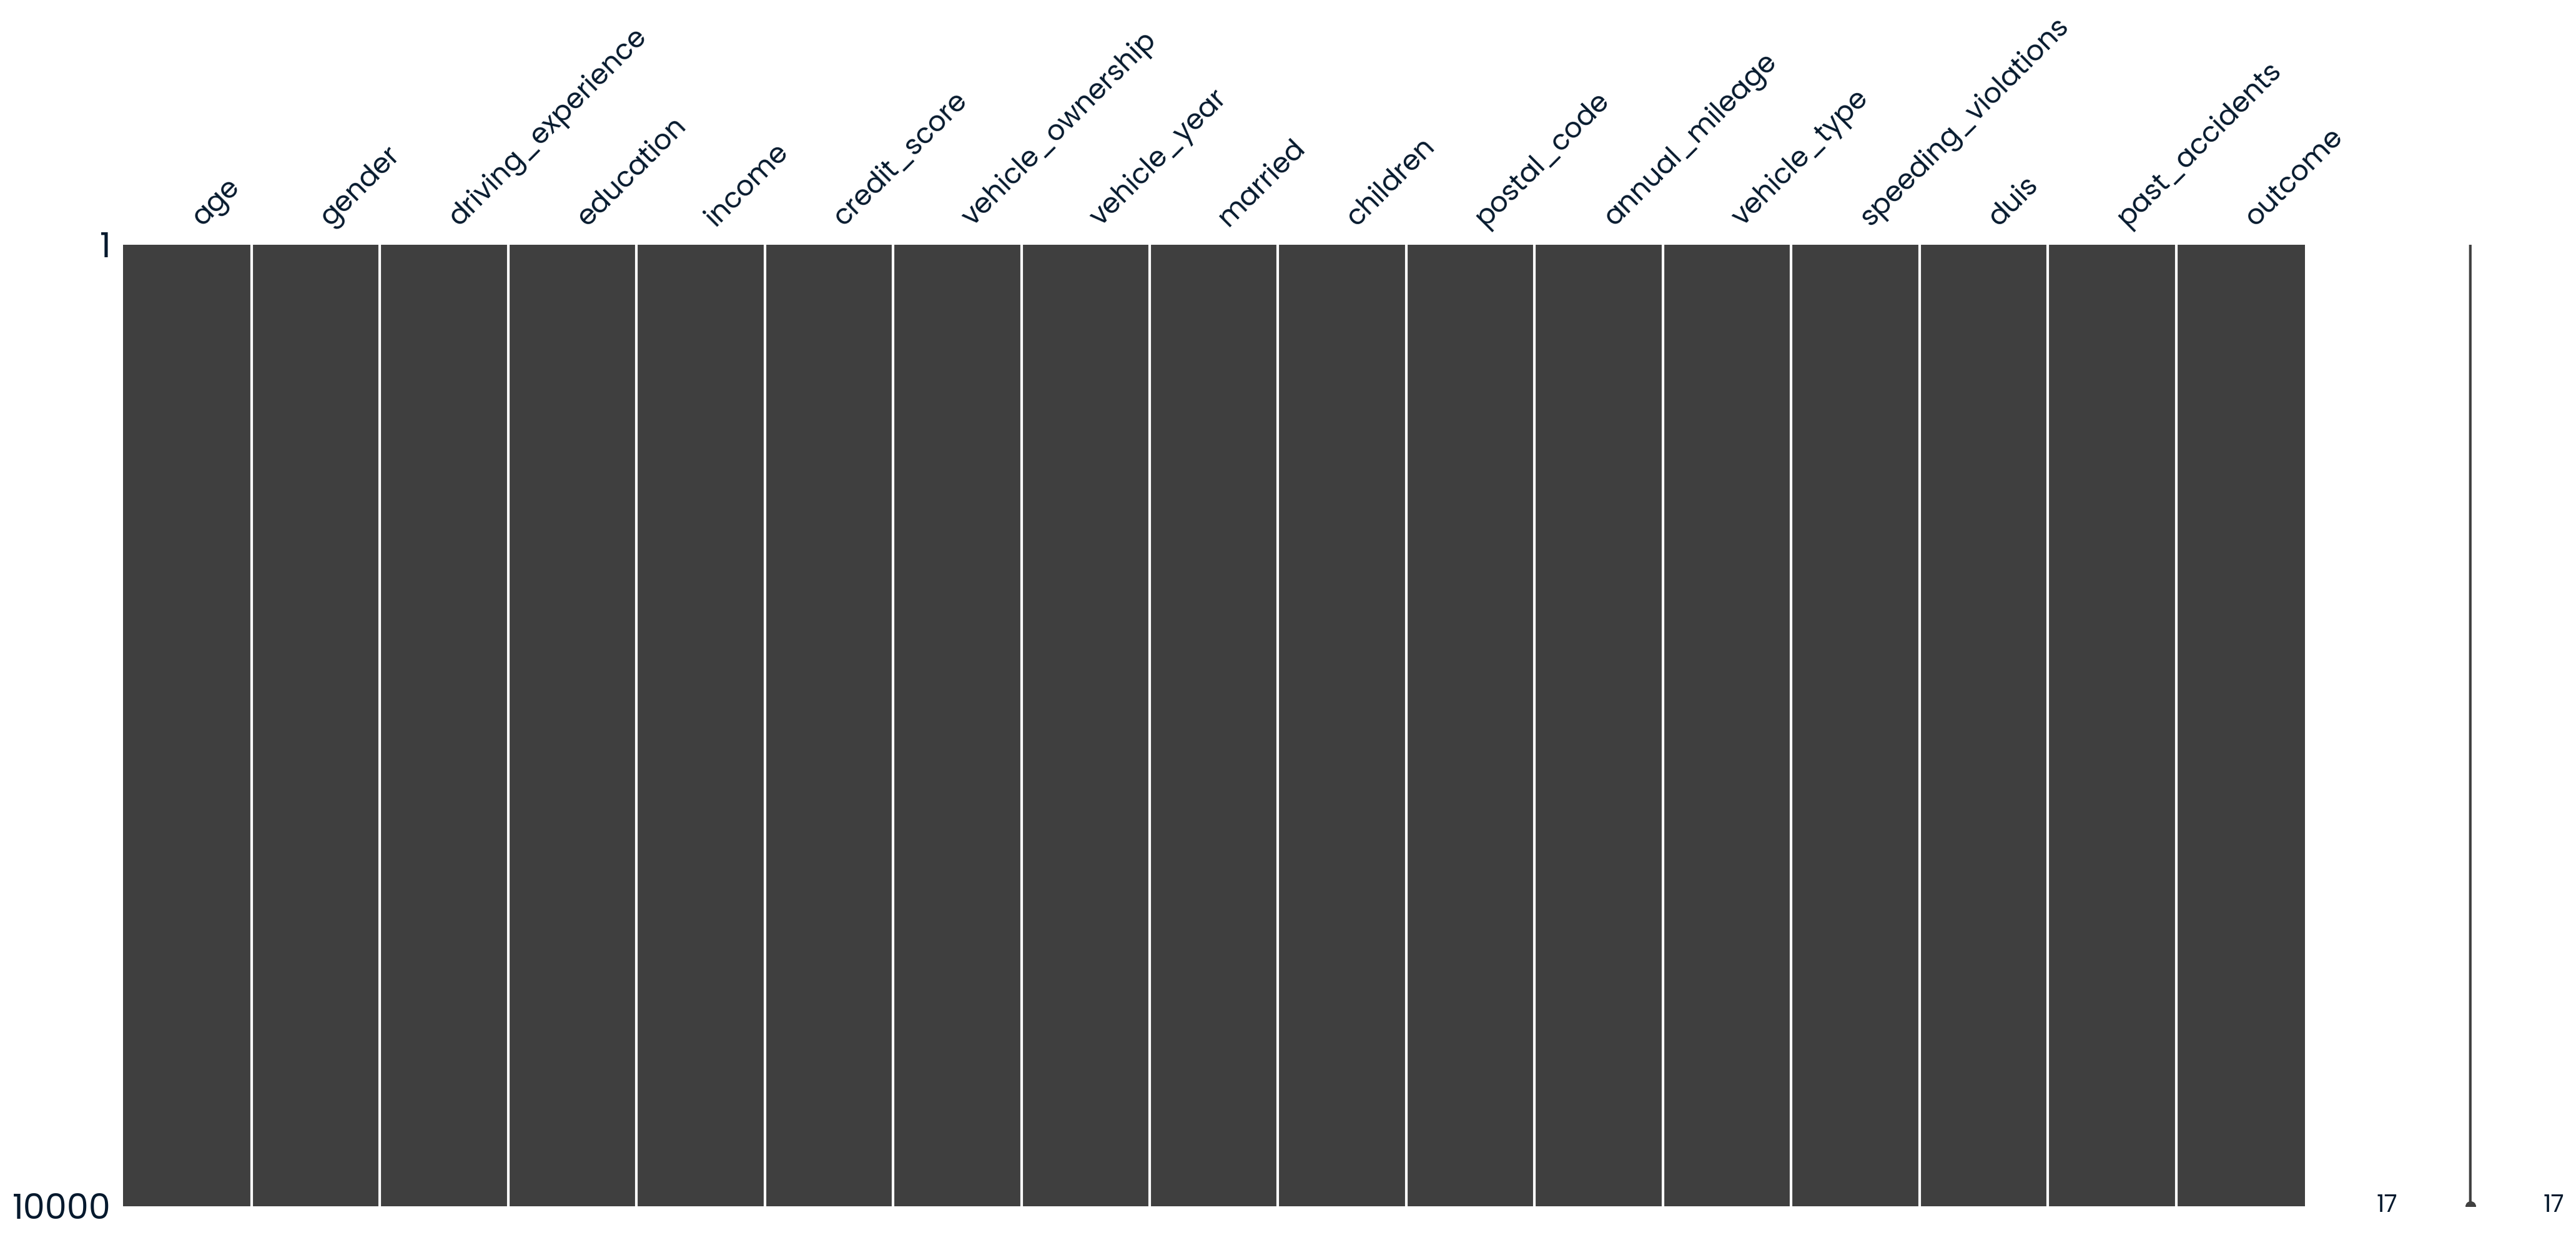

In [253]:
##### Cleaning data
# Can change dtypes for certain groups: e.g. categories
# make outcome contain binary results

# ------------------

# print(df_insurance.isna().sum())

# Credit_score and annual mileage have NaN 
# -> max 20% data need to check if NaN in credit score and annual mileage overlap

import missingno as msno

msno.matrix(df_insurance[['credit_score', 'annual_mileage']])
# forward fill but doesnt make sense in this case
# fillna with .mean could be prefered

fillna__mean_map = {
    "credit_score"   : df_insurance['credit_score'].mean(),
    "annual_mileage" : df_insurance['annual_mileage'].mean()
}

df_insurance.fillna(fillna__mean_map, inplace=True)
# all Nan filled with mean

# Cleaning Data Types
# int
df_insurance['outcome'] = df_insurance['outcome'].astype(int)

## ordinal categories

age_map = {
    0: '16-25',
    1: '26-39',
    2: '40-64',
    3: '65+'
}
print(df_insurance["education"].unique())
print(df_insurance["income"].unique())
print(df_insurance["driving_experience"].unique())
print(df_insurance["age"].unique())

df_insurance["age"] = df_insurance["age"].map(age_map)

education_category = pd.CategoricalDtype(['none','high school','university'], ordered = True)
income_category = pd.CategoricalDtype(['poverty','working class','middle class', 'upper class'], ordered = True)
experience_category = pd.CategoricalDtype(['0-9y','10-19y','20-29y','30y+'], ordered = True)
age_category = pd.CategoricalDtype(['16-25','26-39','40-64','65+'], ordered = True)

df_insurance["age"] = df_insurance["age"].astype(age_category) ## ordinal
df_insurance["driving_experience"] = df_insurance["driving_experience"].astype(experience_category) ## ordinal
df_insurance["education"] = df_insurance["education"].astype(education_category) ## ordinal
df_insurance["income"] = df_insurance["income"].astype(income_category) ## ordinal

## nominal categories
df_insurance["gender"] = df_insurance["gender"].astype("category")
df_insurance["vehicle_type"] = df_insurance["vehicle_type"].astype("category")

msno.matrix(df_insurance)
df_insurance.head()

Identify the single feature of the data that is the best predictor of whether a customer will put in a claim (the "outcome" column), excluding the "id" column.
- run logit on every column with outcome
- find accuracy of each model
- accuracy = TN + TP/ ALL using conf_matrix
- highest accuracy is best model

In [254]:
from statsmodels.formula.api import logit

def logistic_regession_modelling(column1,column2,data_name):
    """
    Runs logit to find the mdl object between 2 columns
    
    Parameters:
    column1: pd series
    column2: pd series
    data_name: pd df contain column 1 and column2
    
    Returns:
    mdlo: model object
    """
    mdl_object = logit(f'{column1} ~ {column2}', data = data_name).fit()
    
    return mdl_object

def calculate_accuracy(mdlo):
    """
    Calculates accuracy of model using TN +TP /ALL
    
    Parameters:
    mdlo: model object
    
    Returns:
    accuracy: float 
    """
    conf_matrix = mdlo.pred_table()
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]
    
    return (TN + TP)/(TN + TP + FN + FP)

mdlo_list = []
mdl_accuracy = {}
features = df_insurance.columns.drop('outcome')

for col in features:
    mdlo = logistic_regession_modelling('outcome', col, df_insurance)
    mdlo_list.append(mdlo)
    accuracy = calculate_accuracy(mdlo)
    mdl_accuracy[col] = accuracy

print(df_insurance.isna().sum())

Optimization terminated successfully.
         Current function value: 0.506484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467092
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.603742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595431
  

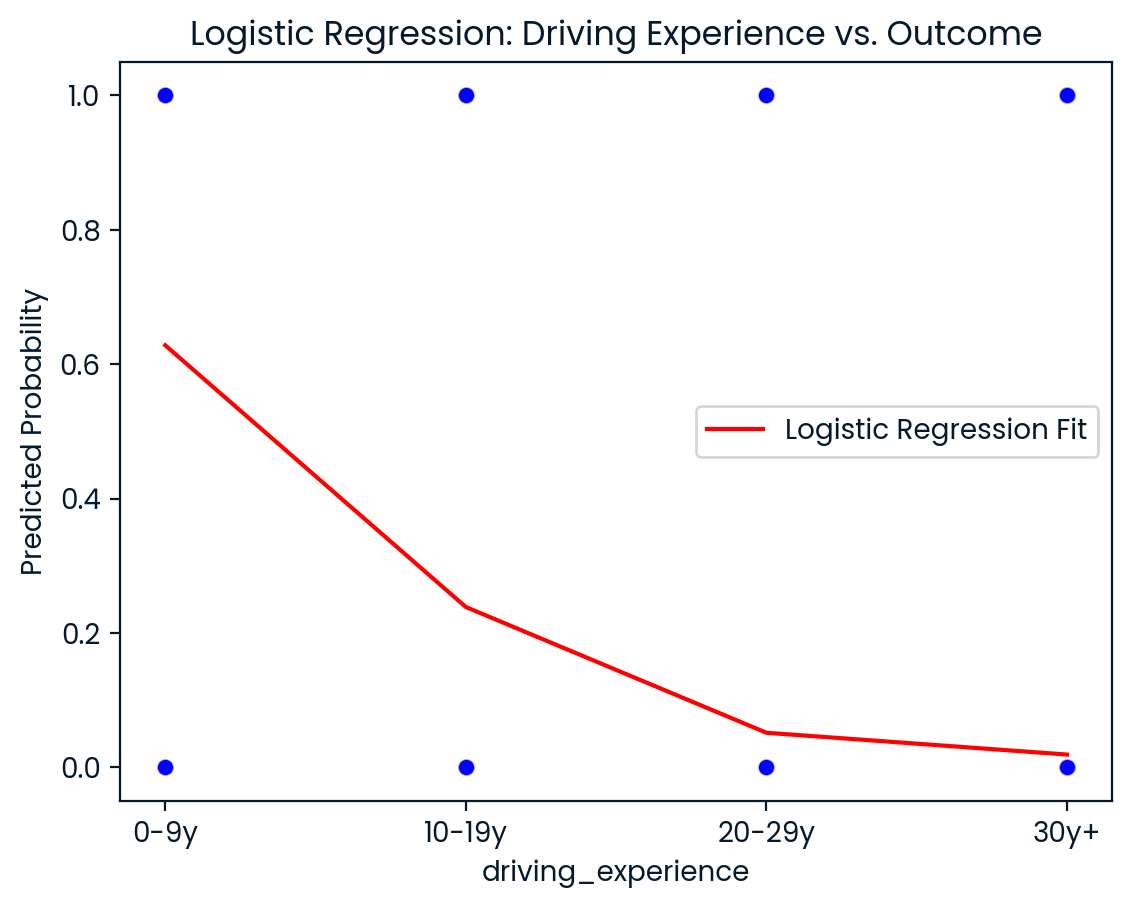

         best_feature  best_accuracy
0  driving_experience         0.7771
2024-10-18 00:29:06.571353


In [255]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def plot_logistic_regression(data, x_column, y_column, model):
    # Create a scatter plot of the data
    sns.scatterplot(data=data, x=x_column, y=y_column, color='blue', alpha=0.5)

    # Create a DataFrame for the sorted unique driving experience values
    experience_range_df = pd.DataFrame({
        x_column: np.sort(data[x_column].unique())
    })

    # Get predicted probabilities for each driving experience
    experience_range_df['predicted_prob'] = model.predict(experience_range_df)

    # Plot the logistic regression line
    sns.lineplot(data=experience_range_df, x=x_column, y='predicted_prob', color='red', label='Logistic Regression Fit')

    plt.xlabel(x_column)
    plt.ylabel('Predicted Probability')
    plt.title('Logistic Regression: Driving Experience vs. Outcome')
    plt.legend()
    plt.show()

best_feature = max(mdl_accuracy, key=mdl_accuracy.get)
max_accuracy = mdl_accuracy[max_feature]
best_model = mdlo_list[list(mdl_accuracy.keys()).index(best_feature)]

best_feature_dict = {
    "best_feature" : [best_feature],
    "best_accuracy": [max_accuracy]    
}

plot_logistic_regression(df_insurance, best_feature, 'outcome', best_model)


best_feature_df = pd.DataFrame(best_feature_dict)
print(best_feature_df.head())

print(datetime.now())